This notebook shows how we computed the CRPS for the different ensembles

In [1]:

from tensorflow.keras.layers import Input, Dense, Concatenate
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps

import torch as to


original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 405

batch_size = 3551

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values
NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the ANN training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai

PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];



    
    


2024-08-26 09:29:31.236860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/b/b309162/.conda/envs/lightning_gpu_V_pytorch/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Load the ANNs

In [2]:
ANN_1_lin=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')
ANN_2_lin=to.jit.load('real_geography/ANNs/ANN_2/ANN_2_CRM_lin_jit.pt')
ANN_3_lin=to.jit.load('real_geography/ANNs/ANN_3/ANN_3_CRM_lin_jit.pt')
ANN_4_lin=to.jit.load('real_geography/ANNs/ANN_4/ANN_4_CRM_lin_jit.pt')
ANN_5_lin=to.jit.load('real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')
ANN_6_lin=to.jit.load('real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')
ANN_7_lin=to.jit.load('real_geography/ANNs/ANN_7/ANN_7_CRM_lin_jit.pt')


In [3]:
# load vertical axis in pressure coords

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai



# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];

from cbrain.data_generator import DataGenerator

In [4]:
#load test data set 

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [5]:
# import CRPS package
import xskillscore as xskill

In [9]:
def crps_ensemble_lin_construction(data_points,sequence_length,ensemble_size,stoch_ens_size):
    
    """
    compute CRPS for \overline{ANN} and ANN-ensemble
    
    author: G.Behrens
    """

    
    
    rand_time_step=np.random.choice(sequence_length,data_points,replace=False)
    ground_truth=np.nan*np.zeros((int(96*144),112))
    ens=np.nan*np.zeros((ensemble_size,int(96*144),112))
    obs=np.nan*np.zeros((int(96*144),113))
    crps_ensemble=np.nan*np.zeros((int(data_points*96*144),112))
    for i in tqdm(np.arange(data_points)):
        stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
        obs=(val_gen_II[rand_time_step[i]][1])
        #print(stoch_ens)

        
        ens[0,:,:]=ANN_1_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[1,:,:]=ANN_2_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[2,:,:]=ANN_4_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[3,:,:]=ANN_5_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[4,:,:]=ANN_6_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[5,:,:]=ANN_7_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[6,:,:]=ANN_3_lin(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()

        if stoch_ens_size < ensemble_size:
            ens_2=xr.DataArray(np.zeros((stoch_ens_size,int(96*144),112)),dims=["member","latlon","SPCESM_var"])
   
            for j in np.arange(int(96*144)):
                stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
                ens_2[:,j]=ens[stoch_ens,j]
        
        else:
            stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)

            ens_2=xr.DataArray(ens[stoch_ens],dims=["member","latlon","SPCESM_var"])

            
                
        obs=xr.DataArray(obs,dims=["latlon","SPCESM_var"])
        
        crps_ensemble[int(i*96*144):int((i+1)*96*144)]=xskill.crps_ensemble(obs,ens_2,dim=[])
        
    del obs, ens_2, ens
    
    crps_ensemble=xr.DataArray(crps_ensemble,dims=["space_time","SPCESM_var"])
        
    return crps_ensemble

In [10]:
# compute CRPS for \overline{ANN} based on 500 random time steps from the test data set 

crps_ensemble_7_mem_lin=crps_ensemble_lin_construction(500,4000,7,7)
crps_ensemble_7_mem_lin_mean=crps_ensemble_7_mem_lin.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [12]:
print(crps_ensemble_7_mem_lin_mean)

<xarray.DataArray (SPCESM_var: 112)>
array([5.34969056e-09, 1.05410711e-08, 1.96086580e-08, 4.76252105e-09,
       4.02872439e-06, 4.74029664e-06, 3.11874281e-06, 5.09531337e-06,
       1.42331765e-05, 5.66681931e-05, 1.91589158e-04, 5.45079883e-04,
       1.28910604e-03, 2.58637926e-03, 4.37008878e-03, 6.52588117e-03,
       9.16231861e-03, 1.29074766e-02, 1.77586413e-02, 2.45763164e-02,
       3.51421892e-02, 4.58936550e-02, 5.70894124e-02, 6.65693510e-02,
       7.23056255e-02, 1.06526019e-01, 1.73898548e-02, 1.30680779e-02,
       1.02020885e-02, 7.64701863e-03, 6.31631411e-03, 5.84843608e-03,
       5.76266877e-03, 9.89655225e-03, 1.31982807e-02, 1.37258557e-02,
       1.33546297e-02, 1.45583978e-02, 1.67493893e-02, 1.96775262e-02,
       2.14419409e-02, 2.23528937e-02, 2.33122026e-02, 2.46353724e-02,
       2.66843366e-02, 2.88311626e-02, 3.30922791e-02, 4.09865133e-02,
       4.76841976e-02, 4.38337652e-02, 4.63254072e-02, 6.62306679e-02,
       1.48289375e-08, 1.60948688e-08, 1

In [8]:
#!mkdir CRPS_real_geo

In [11]:
# save CRPS for \overline{ANN}
crps_ensemble_7_mem_lin.to_netcdf(path='CRPS_real_geo/deter_ANN_7_lin.nc')

In [13]:
#compute CRPS for ANN-ensemble
crps_ensemble_5_mem_lin=crps_ensemble_lin_construction(500,4000,7,5)
crps_ensemble_5_mem_lin_mean=crps_ensemble_5_mem_lin.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [14]:
# save CRPS for ANN-ensemble

crps_ensemble_5_mem_lin.to_netcdf(path='CRPS_real_geo/stoch_ANN_5_lin.nc')

In [14]:
#load ANN-dropout
ANN_1_lin_dr=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')

In [16]:
def crps_ensemble_lin_construction_dr(data_points,sequence_length,ensemble_size,stoch_ens_size):
    
    """
    compute CRPS for ANN-dropout
    
    author: G.Behrens
    
    """
    
    
    rand_time_step=np.random.choice(sequence_length,data_points,replace=False)
    ground_truth=np.nan*np.zeros((int(96*144),112))
    ens=np.nan*np.zeros((ensemble_size,int(96*144),112))
    obs=np.nan*np.zeros((int(96*144),113))
    crps_ensemble=np.nan*np.zeros((int(data_points*96*144),112))
    for i in tqdm(np.arange(data_points)):
        stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
        obs=(val_gen_II[rand_time_step[i]][1])
        #print(stoch_ens)

        
        ens[0,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[1,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[2,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[3,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[4,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[5,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()
        ens[6,:,:]=ANN_1_lin_dr(to.from_numpy(val_gen_II[rand_time_step[i]][0])).detach().numpy()

        
        
        ens_2=xr.DataArray(ens[stoch_ens],dims=["member","latlon","SPCESM_var"])
        obs=xr.DataArray(obs,dims=["latlon","SPCESM_var"])
        
        crps_ensemble[int(i*96*144):int((i+1)*96*144)]=xskill.crps_ensemble(obs,ens_2,dim=[])
        
    del obs, ens_2, ens
    
    crps_ensemble=xr.DataArray(crps_ensemble,dims=["space_time","SPCESM_var"])
        
    return crps_ensemble

In [17]:
# compute CRPS for ANN-dropout
ANN_1_lin_dr_crps_ensemble_7_mem=crps_ensemble_lin_construction_dr(500,4000,7,7)
ANN_1_lin_dr_crps_ensemble_7_mem_mean=ANN_1_lin_dr_crps_ensemble_7_mem.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [18]:
# save CRPS for ANN-dropout
ANN_1_lin_dr_crps_ensemble_7_mem.to_netcdf(path='CRPS_real_geo/ANN_1_lin_dr_0_01_7mem.nc')

In [6]:


out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']


In [7]:
#load test data 

val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [8]:
#load VEDs 

Encoder_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
Decoder_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')

Encoder_2=to.jit.load('real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')
Decoder_2=to.jit.load('real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')

Encoder_3=to.jit.load('real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')
Decoder_3=to.jit.load('real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')

Encoder_4=to.jit.load('real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')
Decoder_4=to.jit.load('real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')

Encoder_5=to.jit.load('real_geography/VEDs/VED_5/VEncoder_5_torch_jit.pt')
Decoder_5=to.jit.load('real_geography/VEDs/VED_5/VDecoder_5_torch_jit.pt')


Encoder_7=to.jit.load('real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')
Decoder_7=to.jit.load('real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')


In [10]:
def VED_crps_ensemble_construction(data_points,sequence_length,ensemble_size,stoch_ens_size):
    
    """
    compute CRPS of \overline{VED}
    
    author: G.Behrens
    
    """
    
    
    rand_time_step=np.random.choice(sequence_length,data_points,replace=False)
    ground_truth=np.nan*np.zeros((int(96*144),113))
    ens=np.nan*np.zeros((ensemble_size,int(96*144),113))
    obs=np.nan*np.zeros((int(96*144),113))
    crps_ensemble=np.nan*np.zeros((int(data_points*96*144),113))
    for i in tqdm(np.arange(data_points)):
        stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
        obs=(val_gen_III[rand_time_step[i]][1])
        #print(stoch_ens)

        
        ens[0,:,:]=Decoder_1(Encoder_1(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()
        ens[1,:,:]=Decoder_2(Encoder_2(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()
        ens[2,:,:]=Decoder_3(Encoder_3(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()
        ens[3,:,:]=Decoder_4(Encoder_4(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()
        ens[4,:,:]=Decoder_5(Encoder_5(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()
        #ens[5,:,:]=Decoder_6(Encoder_6(to.from_numpy(val_gen_II[rand_time_step[i]][0]))).detach().numpy()
        ens[5,:,:]=Decoder_7(Encoder_7(to.from_numpy(val_gen_III[rand_time_step[i]][0]))).detach().numpy()


        
        
        ens_2=xr.DataArray(ens[stoch_ens],dims=["member","latlon","SPCESM_var"])
        obs=xr.DataArray(obs,dims=["latlon","SPCESM_var"])
        
        crps_ensemble[int(i*96*144):int((i+1)*96*144)]=xskill.crps_ensemble(obs,ens_2,dim=[])
        
    del obs, ens_2, ens
    
    crps_ensemble=xr.DataArray(crps_ensemble,dims=["space_time","SPCESM_var"])
        
    return crps_ensemble

In [23]:
# compute and save CRPS for \overline{VED}

VED_crps_ensemble_6_mem=VED_crps_ensemble_construction(500,4000,6,6)
VED_crps_ensemble_6_mem.to_netcdf(path='CRPS_real_geo/deter_VED_6_mem.nc')
VED_crps_ensemble_6_mem_mean=VED_crps_ensemble_6_mem.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
def VED_crps_ensemble_construction_alpha_fix(VDecoder,VEncoder,data_points,sequence_length,ensemble_size,stoch_ens_size,noise_level):
    
    """
    compute CRPS of VED with isotropic latent space manipulation
    
    author: G.Behrens
    
    """

    
    
    rand_time_step=np.random.choice(sequence_length,data_points,replace=False)
    ground_truth=np.nan*np.zeros((int(96*144),113))
    ens=np.nan*np.zeros((ensemble_size,int(96*144),113))
    obs=np.nan*np.zeros((int(96*144),113))
    crps_ensemble=np.nan*np.zeros((int(data_points*96*144),113))
    st_norm_perturb=np.nan*np.zeros((ensemble_size,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_points)):
        stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
        obs=(val_gen_III[rand_time_step[i]][1])
        #print(stoch_ens)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        
        ens[0,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())
        ens[1,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())

        ens[2,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())
        ens[3,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())
        ens[4,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())
        ens[5,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())
        ens[6,:,:]=(VDecoder(to.add(VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())


        
        
        ens_2=xr.DataArray(ens[stoch_ens],dims=["member","latlon","SPCESM_var"])
        obs=xr.DataArray(obs,dims=["latlon","SPCESM_var"])
        
        crps_ensemble[int(i*96*144):int((i+1)*96*144)]=xskill.crps_ensemble(obs,ens_2,dim=[])
        
    del obs, ens_2, ens
    
    crps_ensemble=xr.DataArray(crps_ensemble,dims=["space_time","SPCESM_var"])
        
    return crps_ensemble

In [25]:
#compute CRPS and save for VED-static
VED_1_crps_ensemble_0_5=VED_crps_ensemble_construction_alpha_fix(Decoder_1,Encoder_1,500,4000,7,7,0.5)
VED_1_crps_ensemble_0_5.to_netcdf(path='CRPS_real_geo/VED_1_0_5_7_mem.nc')
VED_1_crps_ensemble_0_5_mean=VED_1_crps_ensemble_0_5.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
#compute CRPS and save for VED-draws

VED_1_crps_ensemble_0_0=VED_crps_ensemble_construction_alpha_fix(Decoder_1,Encoder_1,500,4000,7,7,0.0)
VED_1_crps_ensemble_0_0.to_netcdf(path='CRPS_real_geo/VED_1_0_0_7_mem.nc')
VED_1_crps_ensemble_0_0_mean=VED_1_crps_ensemble_0_0.mean("space_time")

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
def VED_crps_ensemble_construction_alpha_sens(VDecoder,VEncoder,data_points,sequence_length,ensemble_size,stoch_ens_size,noise_level):
    
    """
    compute CRPS of VED with anisotropic latent space manipulation
    
    author: G.Behrens
    
    
    """
    
    
    rand_time_step=np.random.choice(sequence_length,data_points,replace=False)
    ground_truth=np.nan*np.zeros((int(96*144),113))
    ens=np.nan*np.zeros((ensemble_size,int(96*144),113))
    obs=np.nan*np.zeros((int(96*144),113))
    crps_ensemble=np.nan*np.zeros((int(data_points*96*144),113))

    st_norm_perturb=np.nan*np.zeros((ensemble_size,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_points)):
        stoch_ens=np.random.choice(ensemble_size,stoch_ens_size,replace=False)
        obs=(val_gen_III[rand_time_step[i]][1])
        #print(stoch_ens)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        
        ens[0]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[0]).float()).detach().numpy()
        ens[1]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[1]).float()).detach().numpy()
        ens[2]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[2]).float()).detach().numpy()
        ens[3]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[3]).float()).detach().numpy()
        ens[4]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[4]).float()).detach().numpy()
        ens[5]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[5]).float()).detach().numpy()
        ens[6]=VDecoder((VEncoder(to.from_numpy(val_gen_III[rand_time_step[i]][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[6]).float()).detach().numpy()
        

        
        
        ens_2=xr.DataArray(ens[stoch_ens],dims=["member","latlon","SPCESM_var"])
        obs=xr.DataArray(obs,dims=["latlon","SPCESM_var"])
        
        crps_ensemble[int(i*96*144):int((i+1)*96*144)]=xskill.crps_ensemble(obs,ens_2,dim=[])
        
    del obs, ens_2, ens
    
    crps_ensemble=xr.DataArray(crps_ensemble,dims=["space_time","SPCESM_var"])
        
    return crps_ensemble

In [8]:
# compute and save CRPS for VED-varying
VED_1_crps_ensemble_alpha_arr_1=VED_crps_ensemble_construction_alpha_sens(Decoder_1,Encoder_1,
                                                                 500,4000,7,7,np.load('alpha_arrs/alpha_1.npy'))

VED_1_crps_ensemble_alpha_arr_1.to_netcdf(path='CRPS_real_geo/VED_1_alpha_arr_1_7_mem.nc')
VED_1_crps_ensemble_alpha_arr_1_mean=VED_1_crps_ensemble_alpha_arr_1.mean("space_time")

NameError: name 'VED_crps_ensemble_construction_alpha_sens' is not defined

In [ ]:
#load saved CRPS data sets

In [45]:
ANN_1_lin_dr_crps_ensemble_7_mem_mean=xr.load_dataarray('CRPS_real_geo/ANN_1_lin_dr_0_01_7mem.nc').mean("space_time")

crps_ensemble_7_lin_mem_mean=xr.load_dataarray('CRPS_real_geo/deter_ANN_7_lin.nc').mean("space_time")
crps_ensemble_5_lin_mem_mean=xr.load_dataarray('CRPS_real_geo/stoch_ANN_5_lin.nc').mean("space_time")

VED_crps_ensemble_6_mem_mean=xr.load_dataarray('CRPS_real_geo/deter_VED_6_mem.nc').mean("space_time")
VED_1_crps_ensemble_0_0_mean=xr.load_dataarray('CRPS_real_geo/VED_1_0_0_7_mem.nc').mean("space_time")
VED_1_crps_ensemble_0_5_mean=xr.load_dataarray('CRPS_real_geo/VED_1_0_5_7_mem.nc').mean("space_time")
VED_1_crps_ensemble_alpha_arr_1_mean=xr.load_dataarray('CRPS_real_geo/VED_1_alpha_arr_1_7_mem.nc').mean("space_time")


# CRPS Figures

In [10]:
levels=np.hstack((np.arange(0,104)[:],np.arange(105,113)))


In [11]:
#stack CRPS of differnet models
models_updt=np.vstack((ANN_1_lin_dr_crps_ensemble_7_mem_mean,
                 crps_ensemble_7_lin_mem_mean,
                 crps_ensemble_5_lin_mem_mean,
                 VED_crps_ensemble_6_mem_mean[levels],
                 VED_1_crps_ensemble_0_0_mean[levels],
                 VED_1_crps_ensemble_0_5_mean[levels],
                 VED_1_crps_ensemble_alpha_arr_1_mean[levels]))

In [32]:
model_names_updt_2=['DNN-dropout',r'$\overline{\mathrm{DNN}}$', 'DNN-ensemble',r'$\overline{\mathrm{VED}}$'
             ,r'VED-draws',r'VED-static'
            ,r'VED-varying']



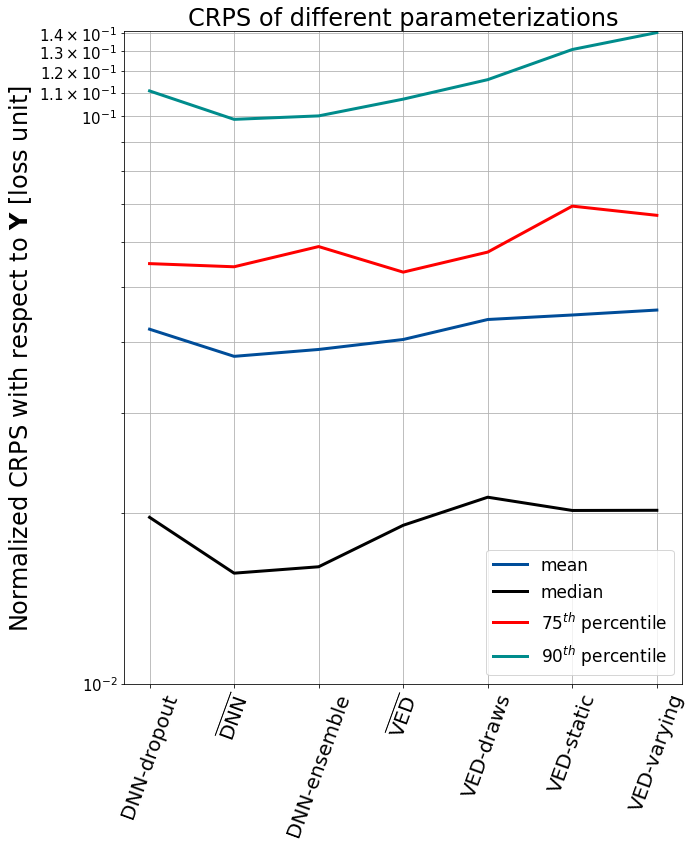

In [33]:
# plot general statistics of CRPS
plt.figure(2,(10,12))

plt.plot(np.mean(models_updt,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
plt.yticks(np.arange(0.02,0.141,0.01),fontsize=15)
plt.yscale('log')
plt.ylim(0.014,0.141)
plt.yticks(np.arange(0.01,0.141,0.01))
plt.title('CRPS of different parameterizations',fontsize=24)
plt.legend(fontsize=17)
plt.ylabel('Normalized CRPS with respect to $\mathbf{Y}$ [loss unit]',fontsize=24)
plt.grid(True)

# Ocean vs. Land 

In [13]:
from mpl_toolkits.basemap import maskoceans
from mpl_toolkits.basemap import Basemap

map = Basemap(projection='sinu', 
              lat_0=0, lon_0=0)

In [18]:
levels=np.hstack((np.arange(0,104)[:],np.arange(105,113)))


In [19]:
ANN_1_lin_dr_0_1=xr.load_dataarray('CRPS_real_geo/ANN_1_lin_dr_0_01_7mem.nc')#[:,levels]
deter_7_ANN_lin_=xr.load_dataarray('CRPS_real_geo/deter_ANN_7_lin.nc')#[:,levels]
stoch_5_ANN_lin_=xr.load_dataarray('CRPS_real_geo/stoch_ANN_5_lin.nc')#[:,levels]
deter_6_VED_=xr.load_dataarray('CRPS_real_geo/deter_VED_6_mem.nc')#[:,levels]
VED_1_0_0_7_=xr.load_dataarray('CRPS_real_geo/VED_1_0_0_7_mem.nc')#[:,levels]
VED_1_0_5_7_=xr.load_dataarray('CRPS_real_geo/VED_1_0_5_7_mem.nc')
VED_1_alpha_arr_1_7_=xr.load_dataarray('CRPS_real_geo/VED_1_alpha_arr_1_7_mem.nc')#[:,levels]

In [20]:
ANN_1_lin_dr_0_1_lev=ANN_1_lin_dr_0_1
deter_7_ANN_lin_lev=deter_7_ANN_lin_
stoch_5_ANN_lin_lev=stoch_5_ANN_lin_
deter_6_VED_lev_=deter_6_VED_.values[:,levels]
VED_1_0_0_7_lev_=VED_1_0_0_7_.values[:,levels]
VED_1_0_5_7_lev_=VED_1_0_5_7_.values[:,levels]
VED_1_alpha_arr_1_7_lev_=VED_1_alpha_arr_1_7_.values[:,levels]

In [21]:
lat=np.arange(-90,90,180/96)
lon=np.arange(0,360,360/144)

In [23]:
#shift data 
Lons,Lats = np.meshgrid(lon,lat)
lons_2, data_shift = map.shiftdata(Lons, datain = np.reshape(ANN_1_lin_dr_0_1_lev.values[0:int(lat.size*lon.size),24],
                                                             (lat.size,lon.size)) 
                                                             , lon_0=0)

In [24]:
lat=np.arange(-90,90,180/96)
lon=np.arange(0,360,360/144)

In [25]:
# select ocean and land grid cells
MaskedArray_2 = maskoceans(lons_2,Lats,np.reshape(ANN_1_lin_dr_0_1_lev.values[0:int(lat.size*lon.size),24],
                                                             (lat.size,lon.size)),resolution='f',grid=1.25,inlands=False)


In [27]:
ocean=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==True)[0]
land=np.where(np.reshape(MaskedArray_2.mask,(lat.size*lon.size))==False)[0]

In [28]:
# ocean and land grid cells of entire subset
ocean_ext=np.nan*np.zeros((500,ocean.size))
land_ext=np.nan*np.zeros((500,land.size))
for i in np.arange(0,500):
    ocean_ext[i]=ocean+int(i*lat.size*lon.size)
    land_ext[i]=land+int(i*lat.size*lon.size)

ocean_ext_resh=np.reshape(ocean_ext,(500*ocean.size))
land_ext_resh=np.reshape(land_ext,(500*land.size))

In [29]:
# land CRPS mean
models_updt_land=np.vstack((np.mean(ANN_1_lin_dr_0_1_lev[np.int_(land_ext_resh)],0),
                 np.mean(deter_7_ANN_lin_lev[np.int_(land_ext_resh)],0),
                 np.mean(stoch_5_ANN_lin_lev[np.int_(land_ext_resh)],0),
                 np.mean(deter_6_VED_lev_[np.int_(land_ext_resh)],0),
                 np.mean(VED_1_0_0_7_lev_[np.int_(land_ext_resh)],0),
                 np.mean(VED_1_0_5_7_lev_[np.int_(land_ext_resh)],0),
                 np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(land_ext_resh)],0)))

In [30]:
# ocean CRPS mean
models_updt_ocean=np.vstack((np.mean(ANN_1_lin_dr_0_1_lev[np.int_(ocean_ext_resh)],0),
                 np.mean(deter_7_ANN_lin_lev[np.int_(ocean_ext_resh)],0),
                 np.mean(stoch_5_ANN_lin_lev[np.int_(ocean_ext_resh)],0),
                 np.mean(deter_6_VED_lev_[np.int_(ocean_ext_resh)],0),
                 np.mean(VED_1_0_0_7_lev_[np.int_(ocean_ext_resh)],0),
                 np.mean(VED_1_0_5_7_lev_[np.int_(ocean_ext_resh)],0),
                 np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(ocean_ext_resh)],0)))

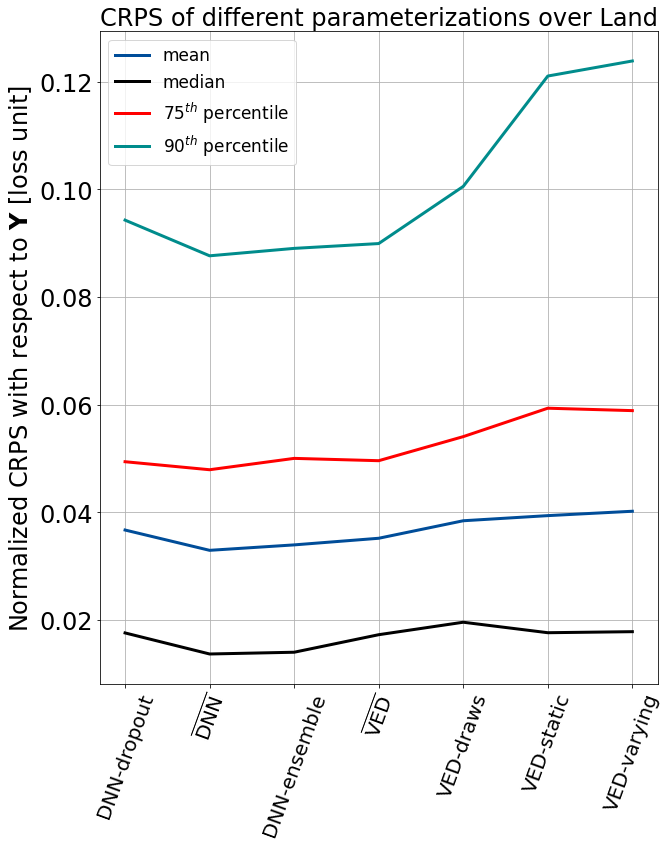

In [34]:
# plot general statistics of CRPS over Land
plt.figure(2,(10,12))

plt.plot(np.mean(models_updt_land,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt_land,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt_land,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt_land,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
#plt.yticks(np.arange(0.02,0.141,0.01),fontsize=15)
plt.yticks(fontsize=24)
#plt.yscale('log')
#plt.ylim(0.014,0.141)
plt.title('CRPS of different parameterizations over Land',fontsize=24)
plt.legend(fontsize=17)
plt.ylabel('Normalized CRPS with respect to $\mathbf{Y}$ [loss unit]',fontsize=24)
plt.grid(True)

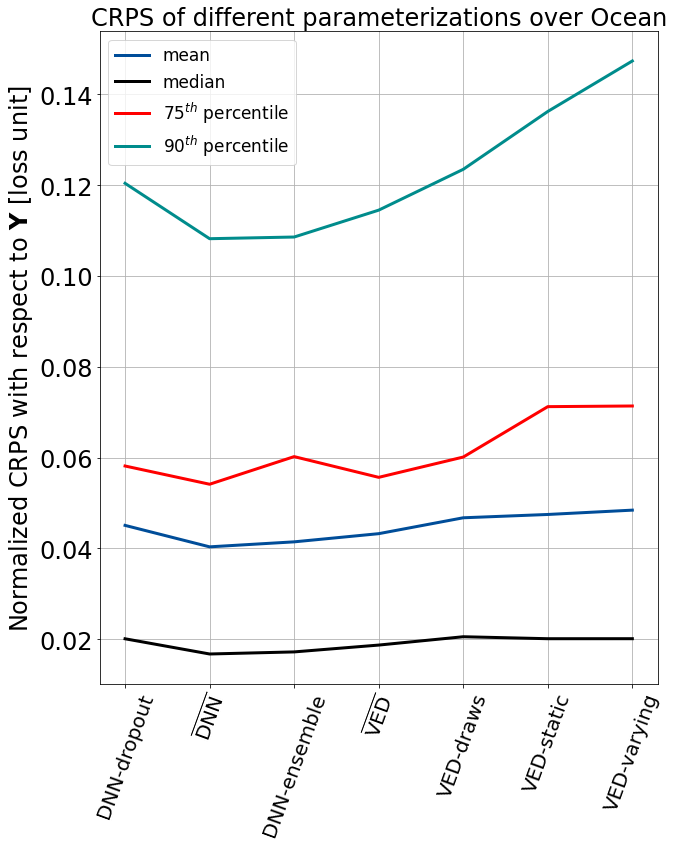

In [35]:
# plot general statistics of CRPS over Ocean
plt.figure(2,(10,12))

plt.plot(np.mean(models_updt_ocean,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt_ocean,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt_ocean,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt_ocean,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
#plt.yticks(np.arange(0.02,0.141,0.01),fontsize=15)
plt.yticks(fontsize=24)
#plt.yscale('log')
#plt.ylim(0.014,0.141)
plt.title('CRPS of different parameterizations over Ocean',fontsize=24)
plt.legend(fontsize=17)
plt.ylabel('Normalized CRPS with respect to $\mathbf{Y}$ [loss unit]',fontsize=24)
plt.grid(True)

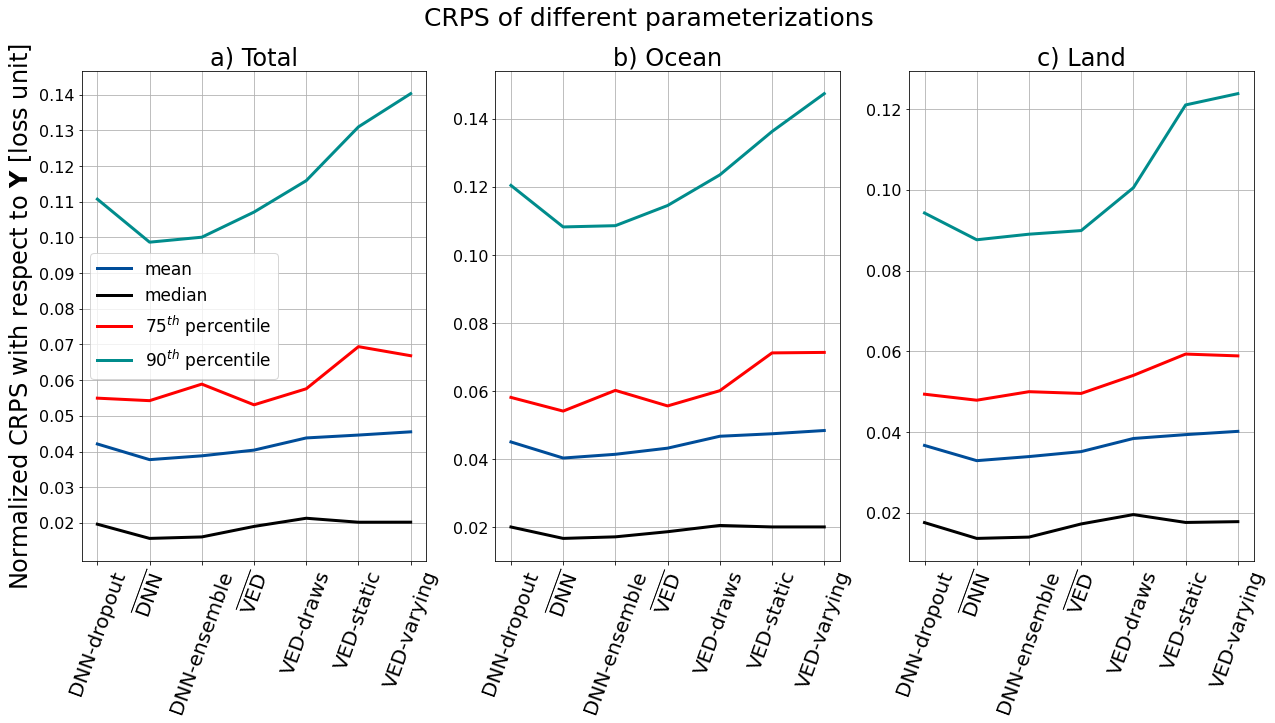

In [36]:
plt.figure(2,(21,9))

plt.suptitle('CRPS of different parameterizations',fontsize=25)

plt.subplot(1,3,1)

plt.plot(np.mean(models_updt,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
plt.yticks(np.arange(0.02,0.141,0.01),fontsize=15)
plt.yticks(fontsize=16)

plt.title('a) Total',fontsize=24)
plt.legend(fontsize=17)
plt.ylabel('Normalized CRPS with respect to $\mathbf{Y}$ [loss unit]',fontsize=24)
plt.grid(True)

plt.subplot(1,3,2)

plt.plot(np.mean(models_updt_ocean,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt_ocean,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt_ocean,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt_ocean,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
plt.yticks(fontsize=16)
plt.title('b) Ocean',fontsize=24)

plt.grid(True)

plt.subplot(1,3,3)

plt.plot(np.mean(models_updt_land,1),linewidth=3,color=[0,0.3,0.6],label=r'mean')
plt.plot(np.median(models_updt_land,1),linewidth=3,color='k',label='median')
plt.plot(np.percentile(models_updt_land,75,1),linewidth=3,color='r',label=r'75$^{th}$ percentile')
plt.plot(np.percentile(models_updt_land,90,1),linewidth=3,color=[0,0.55,0.55],label=r'90$^{th}$ percentile')
plt.xticks(np.arange(0,7),labels=model_names_updt_2,fontsize=20,rotation=70)
plt.yticks(fontsize=16)

plt.title('c) Land',fontsize=24)
plt.grid(True)

# Vertical profiles

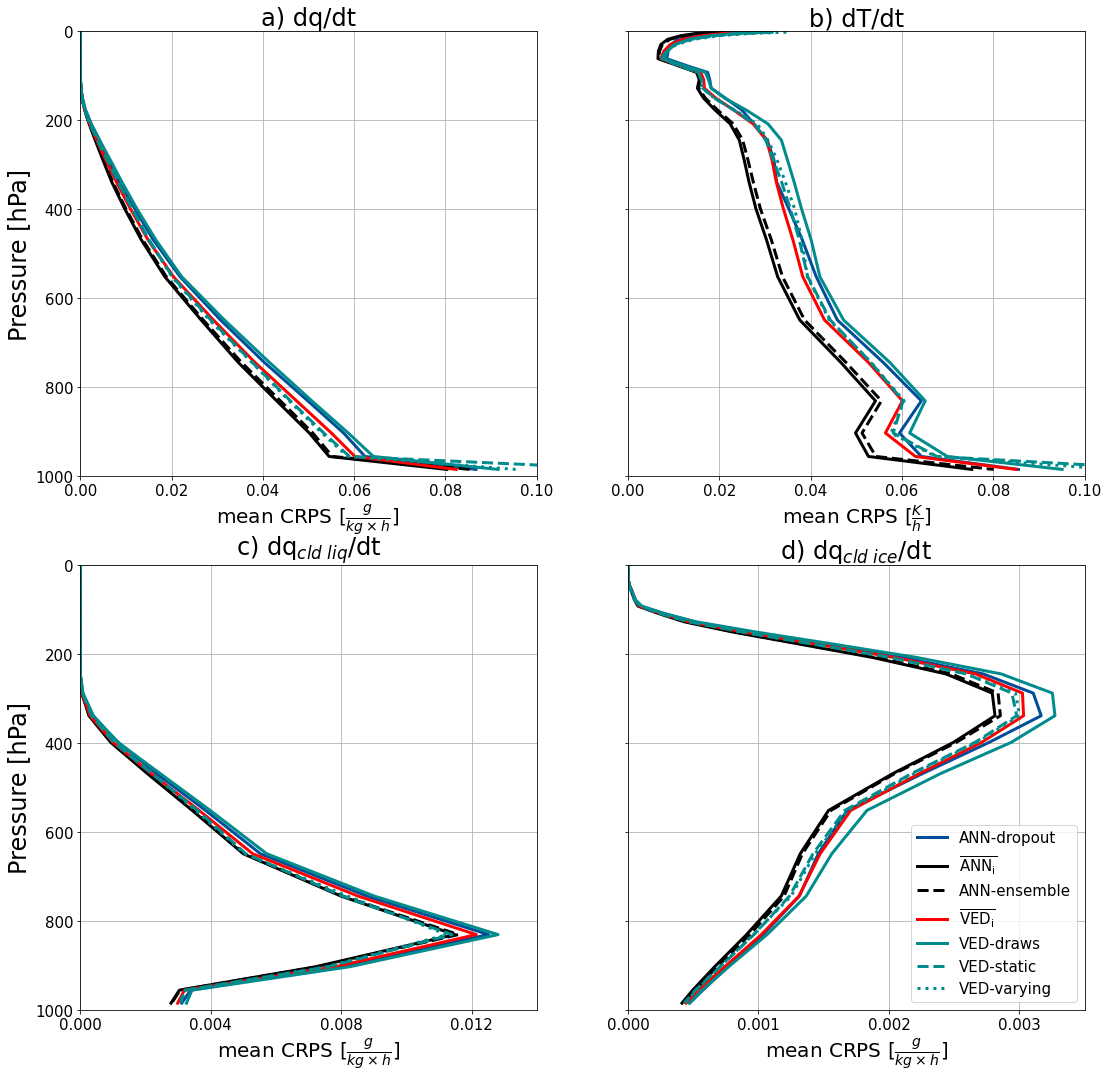

In [37]:
plt.figure(1,(18,18))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*ANN_1_lin_dr_crps_ensemble_7_mem_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*crps_ensemble_7_lin_mem_mean[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*crps_ensemble_5_lin_mem_mean[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*VED_crps_ensemble_6_mem_mean[0:26],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')

plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_0_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED 1 7 draws')

plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_5_mean[0:26],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_alpha_arr_1_mean[0:26],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=20)
plt.title('a) dq/dt',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*crps_ensemble_7_lin_mem_mean[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*crps_ensemble_5_lin_mem_mean[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*VED_crps_ensemble_6_mem_mean[26:52],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')

plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_0_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED 1 7 draws')

plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_5_mean[26:52],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*VED_1_crps_ensemble_alpha_arr_1_mean[26:52],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=20)
plt.title('b) dT/dt',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_7_lin_mem_mean[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_5_lin_mem_mean[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_crps_ensemble_6_mem_mean[52:78],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_0_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED 1 7 draws')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_5_mean[52:78],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[52:78],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.004))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=20)
plt.title('c) dq$_{cld \ liq}$/dt',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_7_lin_mem_mean[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_5_lin_mem_mean[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_crps_ensemble_6_mem_mean[78:104],P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED_i}}$')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_0_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_5_mean[78:104],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[78:104],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0035)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=20)
plt.title('d) dq$_{cld \ ice}$/dt',fontsize=24)
plt.legend(fontsize=15,loc=4)


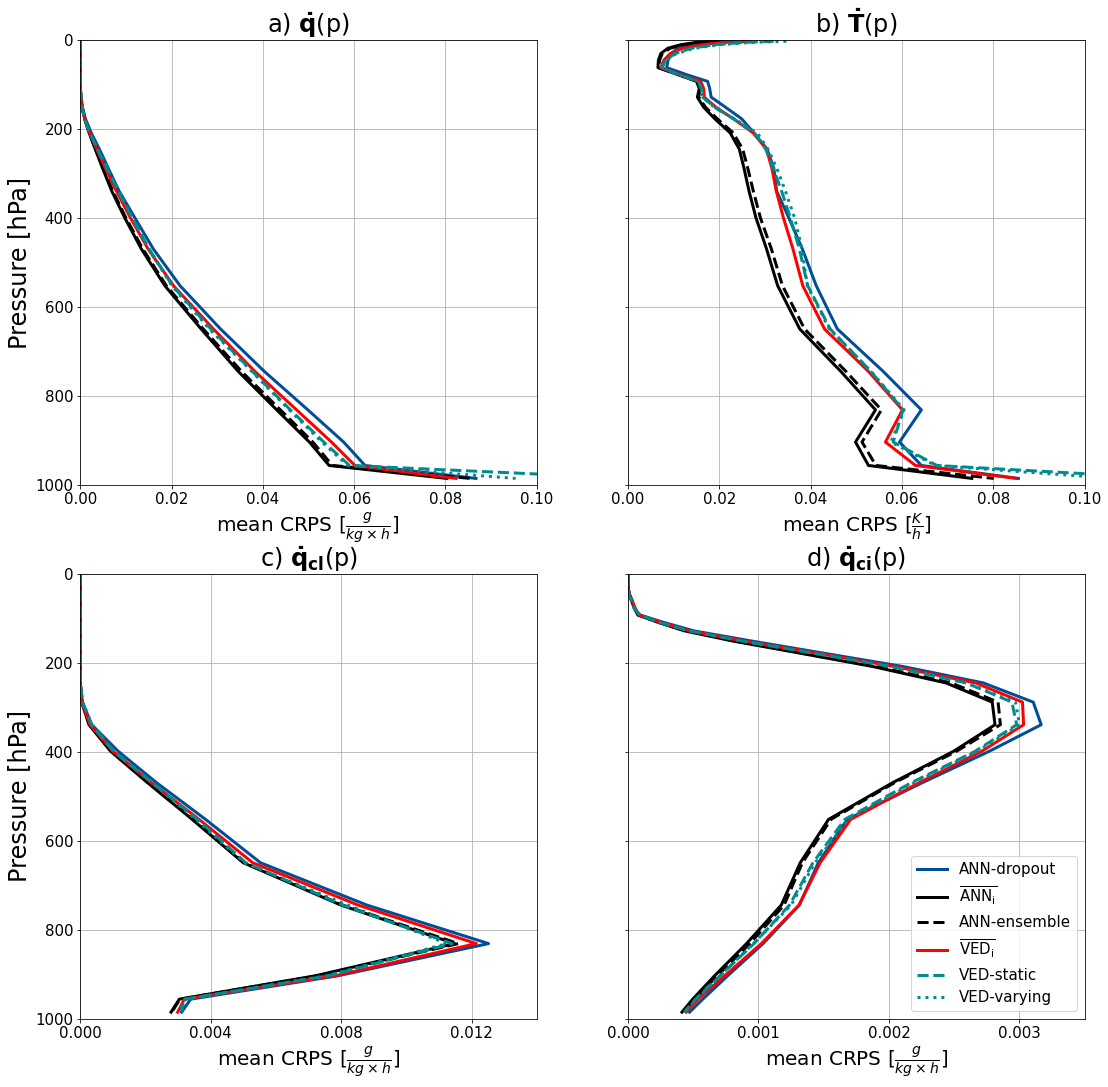

In [38]:
plt.figure(1,(18,18))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*ANN_1_lin_dr_crps_ensemble_7_mem_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*crps_ensemble_7_lin_mem_mean[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*crps_ensemble_5_lin_mem_mean[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*VED_crps_ensemble_6_mem_mean[0:26],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_5_mean[0:26],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_alpha_arr_1_mean[0:26],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=20)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*crps_ensemble_7_lin_mem_mean[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*crps_ensemble_5_lin_mem_mean[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*VED_crps_ensemble_6_mem_mean[26:52],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_5_mean[26:52],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*VED_1_crps_ensemble_alpha_arr_1_mean[26:52],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=20)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_7_lin_mem_mean[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_5_lin_mem_mean[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_crps_ensemble_6_mem_mean[52:78],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_5_mean[52:78],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[52:78],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.004))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=20)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_7_lin_mem_mean[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_5_lin_mem_mean[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_crps_ensemble_6_mem_mean[78:104],P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED_i}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_5_mean[78:104],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[78:104],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0035)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=20)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=15,loc=4)


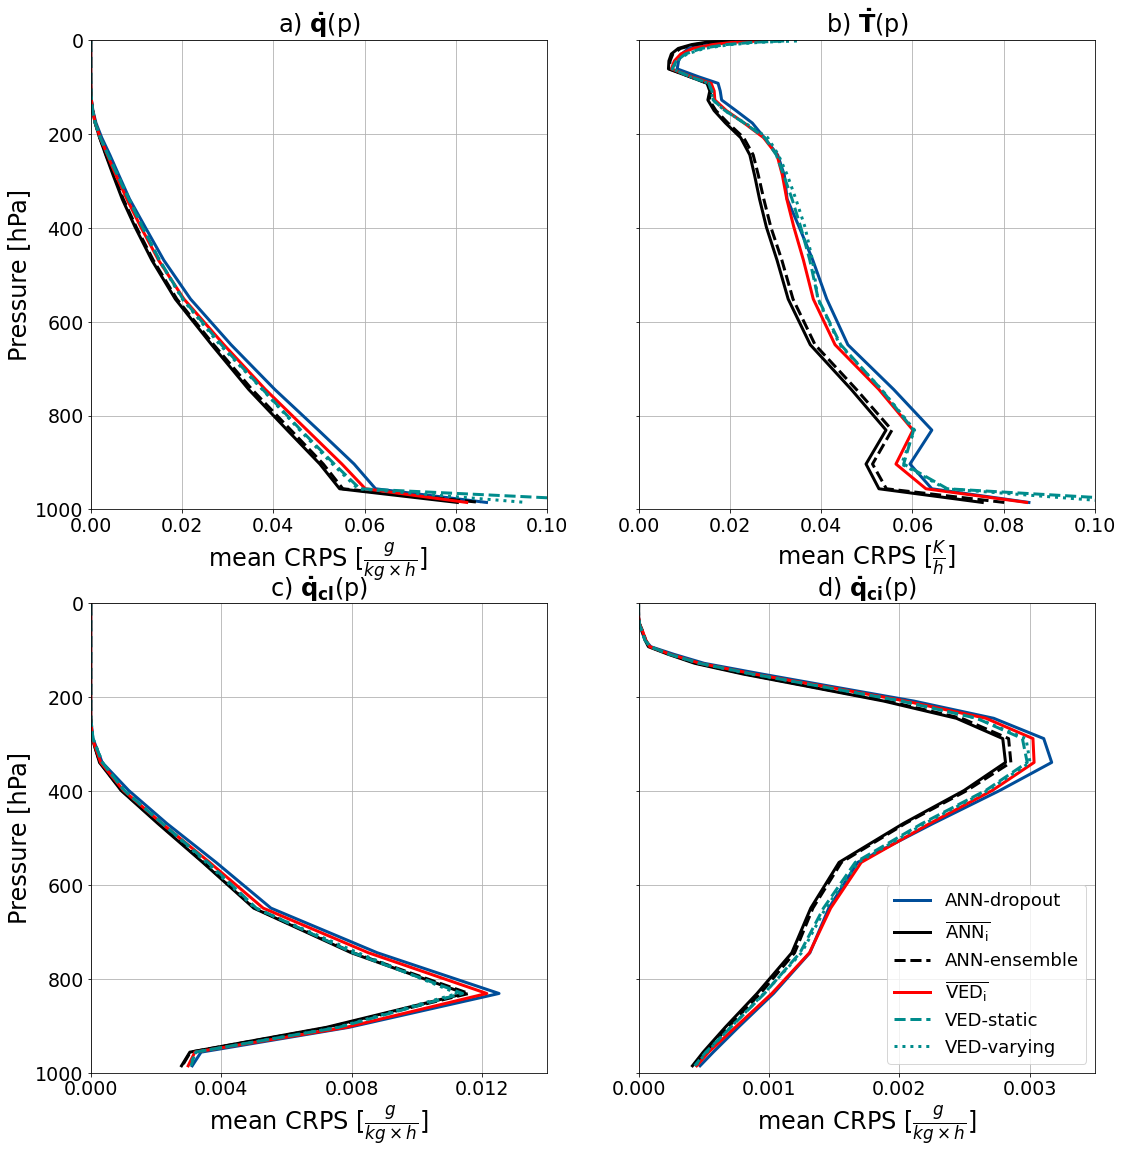

In [39]:
plt.figure(1,(18,19))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*ANN_1_lin_dr_crps_ensemble_7_mem_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*crps_ensemble_7_lin_mem_mean[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*crps_ensemble_5_lin_mem_mean[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*VED_crps_ensemble_6_mem_mean[0:26],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_5_mean[0:26],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_alpha_arr_1_mean[0:26],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*crps_ensemble_7_lin_mem_mean[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*crps_ensemble_5_lin_mem_mean[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*VED_crps_ensemble_6_mem_mean[26:52],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_5_mean[26:52],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*VED_1_crps_ensemble_alpha_arr_1_mean[26:52],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_7_lin_mem_mean[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_5_lin_mem_mean[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_crps_ensemble_6_mem_mean[52:78],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_5_mean[52:78],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[52:78],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.004))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_7_lin_mem_mean[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_5_lin_mem_mean[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_crps_ensemble_6_mem_mean[78:104],P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED_i}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_5_mean[78:104],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[78:104],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0035)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)


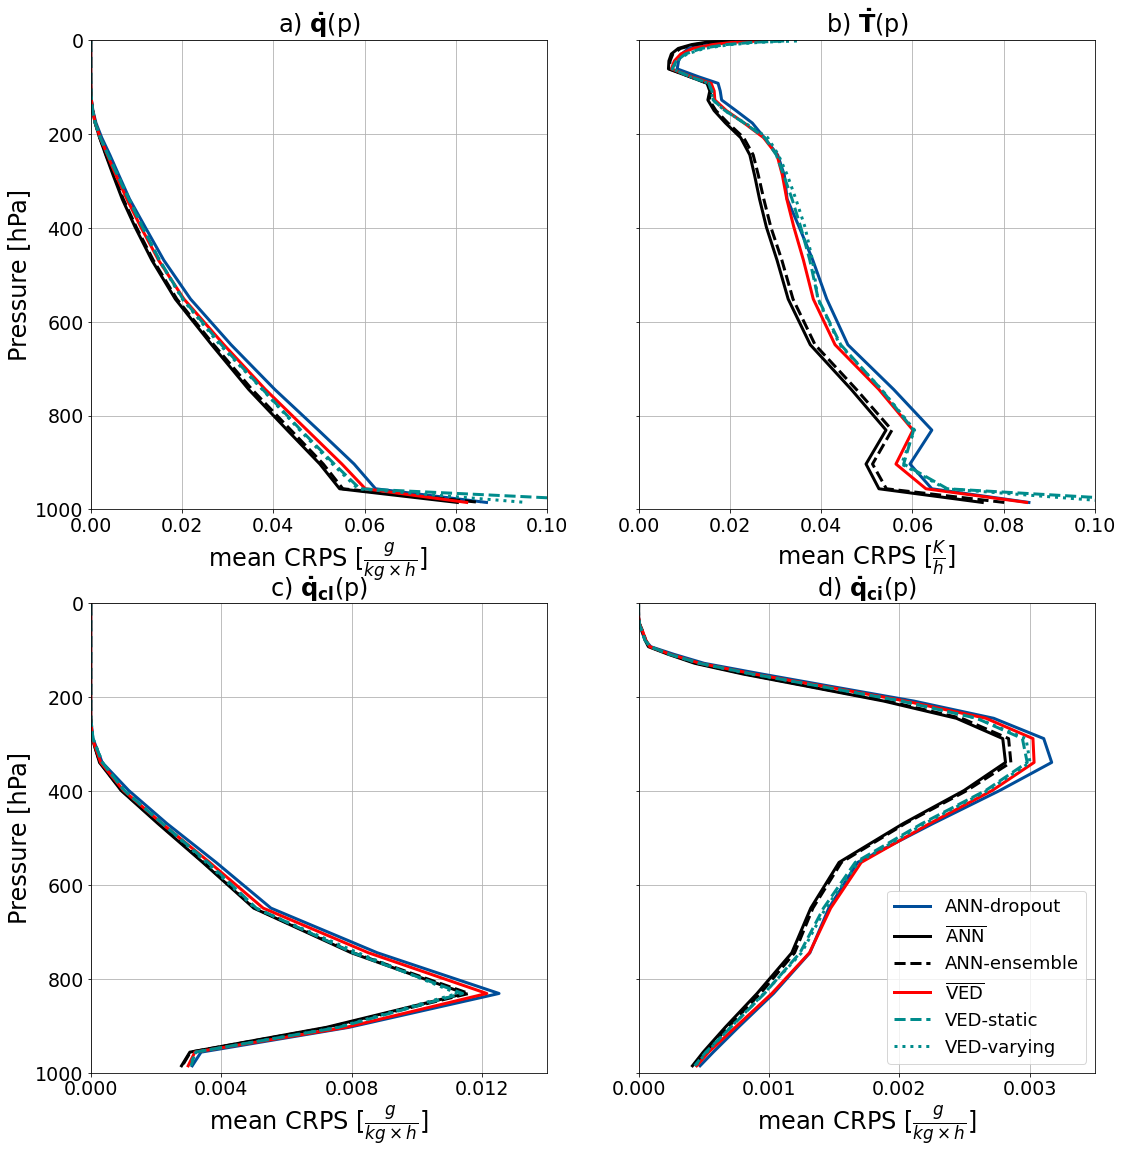

In [40]:
plt.figure(1,(18,19))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*ANN_1_lin_dr_crps_ensemble_7_mem_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*crps_ensemble_7_lin_mem_mean[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*crps_ensemble_5_lin_mem_mean[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*VED_crps_ensemble_6_mem_mean[0:26],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_5_mean[0:26],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_alpha_arr_1_mean[0:26],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*crps_ensemble_7_lin_mem_mean[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*crps_ensemble_5_lin_mem_mean[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*VED_crps_ensemble_6_mem_mean[26:52],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_5_mean[26:52],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*VED_1_crps_ensemble_alpha_arr_1_mean[26:52],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_7_lin_mem_mean[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_5_lin_mem_mean[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_crps_ensemble_6_mem_mean[52:78],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_5_mean[52:78],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[52:78],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.004))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_7_lin_mem_mean[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{ANN}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_5_lin_mem_mean[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_crps_ensemble_6_mem_mean[78:104],P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_5_mean[78:104],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[78:104],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0035)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)


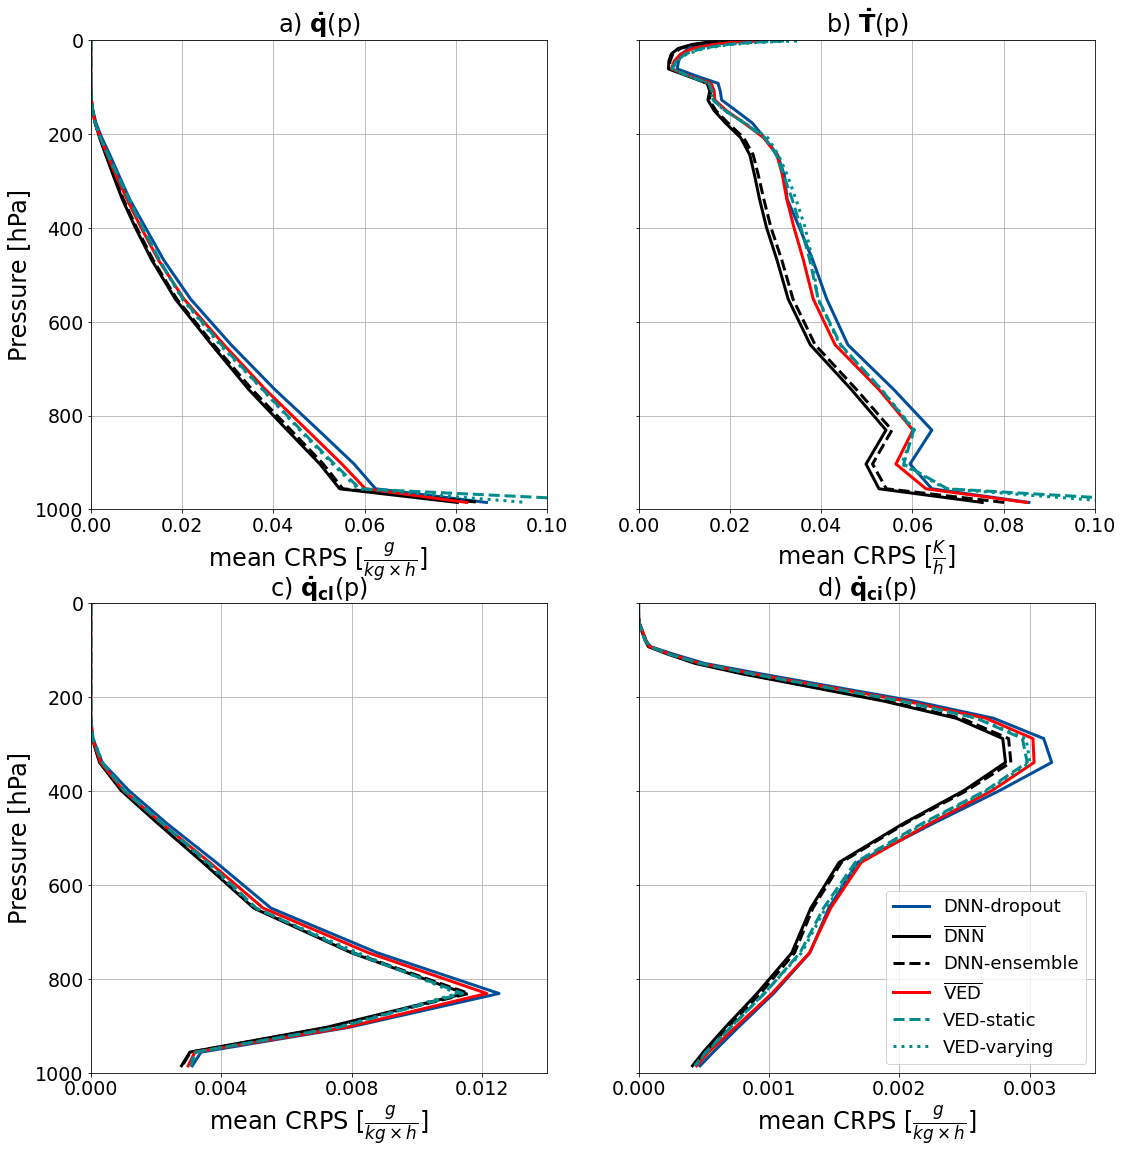

In [41]:
plt.figure(1,(18,19))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*ANN_1_lin_dr_crps_ensemble_7_mem_mean[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*crps_ensemble_7_lin_mem_mean[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*crps_ensemble_5_lin_mem_mean[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*VED_crps_ensemble_6_mem_mean[0:26],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_0_5_mean[0:26],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*VED_1_crps_ensemble_alpha_arr_1_mean[0:26],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*crps_ensemble_7_lin_mem_mean[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*crps_ensemble_5_lin_mem_mean[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*VED_crps_ensemble_6_mem_mean[26:52],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*VED_1_crps_ensemble_0_5_mean[26:52],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*VED_1_crps_ensemble_alpha_arr_1_mean[26:52],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_7_lin_mem_mean[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*crps_ensemble_5_lin_mem_mean[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*VED_crps_ensemble_6_mem_mean[52:78],P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_0_5_mean[52:78],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[52:78],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.004))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*ANN_1_lin_dr_crps_ensemble_7_mem_mean[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_7_lin_mem_mean[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{DNN}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*crps_ensemble_5_lin_mem_mean[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'DNN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*VED_crps_ensemble_6_mem_mean[78:104],P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_0_5_mean[78:104],P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*VED_1_crps_ensemble_alpha_arr_1_mean[78:104],P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0035)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)


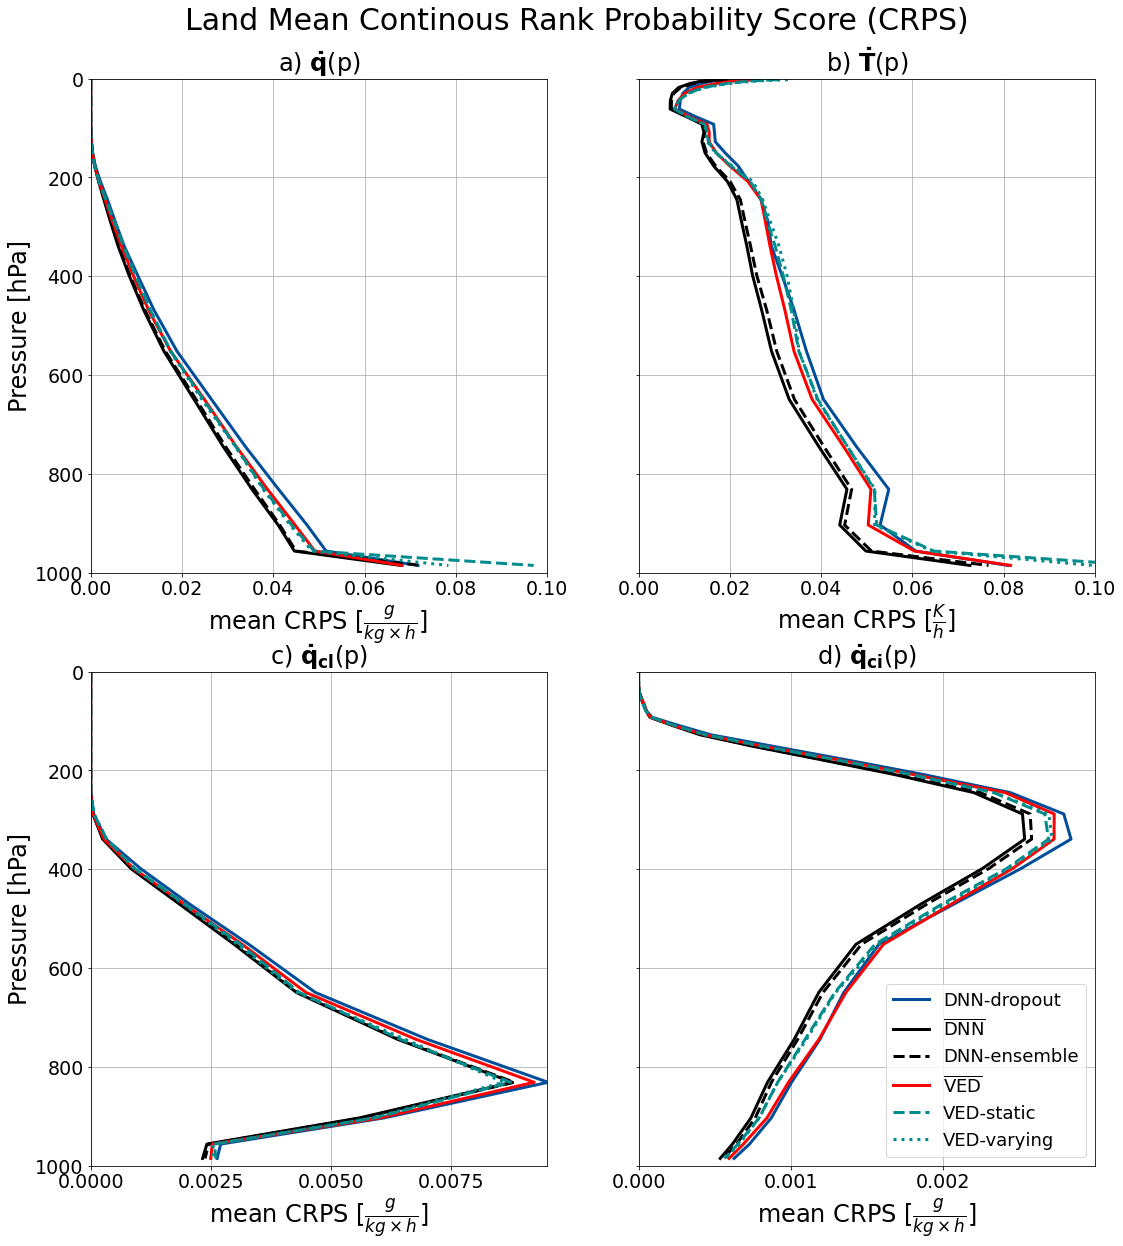

In [42]:
# Land CRPS profiles


plt.figure(1,(18,20))

plt.suptitle('Land Mean Continous Rank Probability Score (CRPS)',fontsize=30,y=0.93)

plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(land_ext_resh),0:26],0)
                                        ,P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*np.mean(deter_7_ANN_lin_lev[np.int_(land_ext_resh),0:26],0)
         ,P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*np.mean(stoch_5_ANN_lin_lev[np.int_(land_ext_resh),0:26],0)
         ,P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*np.mean(deter_6_VED_lev_[np.int_(land_ext_resh),0:26],0)
         ,P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*np.mean(VED_1_0_5_7_lev_[np.int_(land_ext_resh),0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(land_ext_resh),0:26],0)
         ,P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(land_ext_resh),26:52],0),
                              P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*np.mean(deter_7_ANN_lin_lev[np.int_(land_ext_resh),26:52],0),
         P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*np.mean(stoch_5_ANN_lin_lev[np.int_(land_ext_resh),26:52],0),
         P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*np.mean(deter_6_VED_lev_[np.int_(land_ext_resh),26:52],0),
         P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*np.mean(VED_1_0_5_7_lev_[np.int_(land_ext_resh),26:52],0),
         P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(land_ext_resh),26:52],0),
         P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(deter_7_ANN_lin_lev[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(stoch_5_ANN_lin_lev[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(deter_6_VED_lev_[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(VED_1_0_5_7_lev_[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(land_ext_resh),52:78],0),
         P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')





sr=plt.gca()
plt.xticks(np.arange(0,0.0095,0.0025))
plt.xlim(0,0.0095)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(deter_7_ANN_lin_lev[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,
         color='k',label=r'$\mathrm{\overline{DNN}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(stoch_5_ANN_lin_lev[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,'--',linewidth=3,
         color='k',label=r'DNN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(deter_6_VED_lev_[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,
         color='r',label=r'$\mathrm{\overline{VED}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(VED_1_0_5_7_lev_[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,'--',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(land_ext_resh),78:104],0),
         P[0:26]/100,':',
         linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.003,1E-3))

plt.xlim(0,0.0030)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)



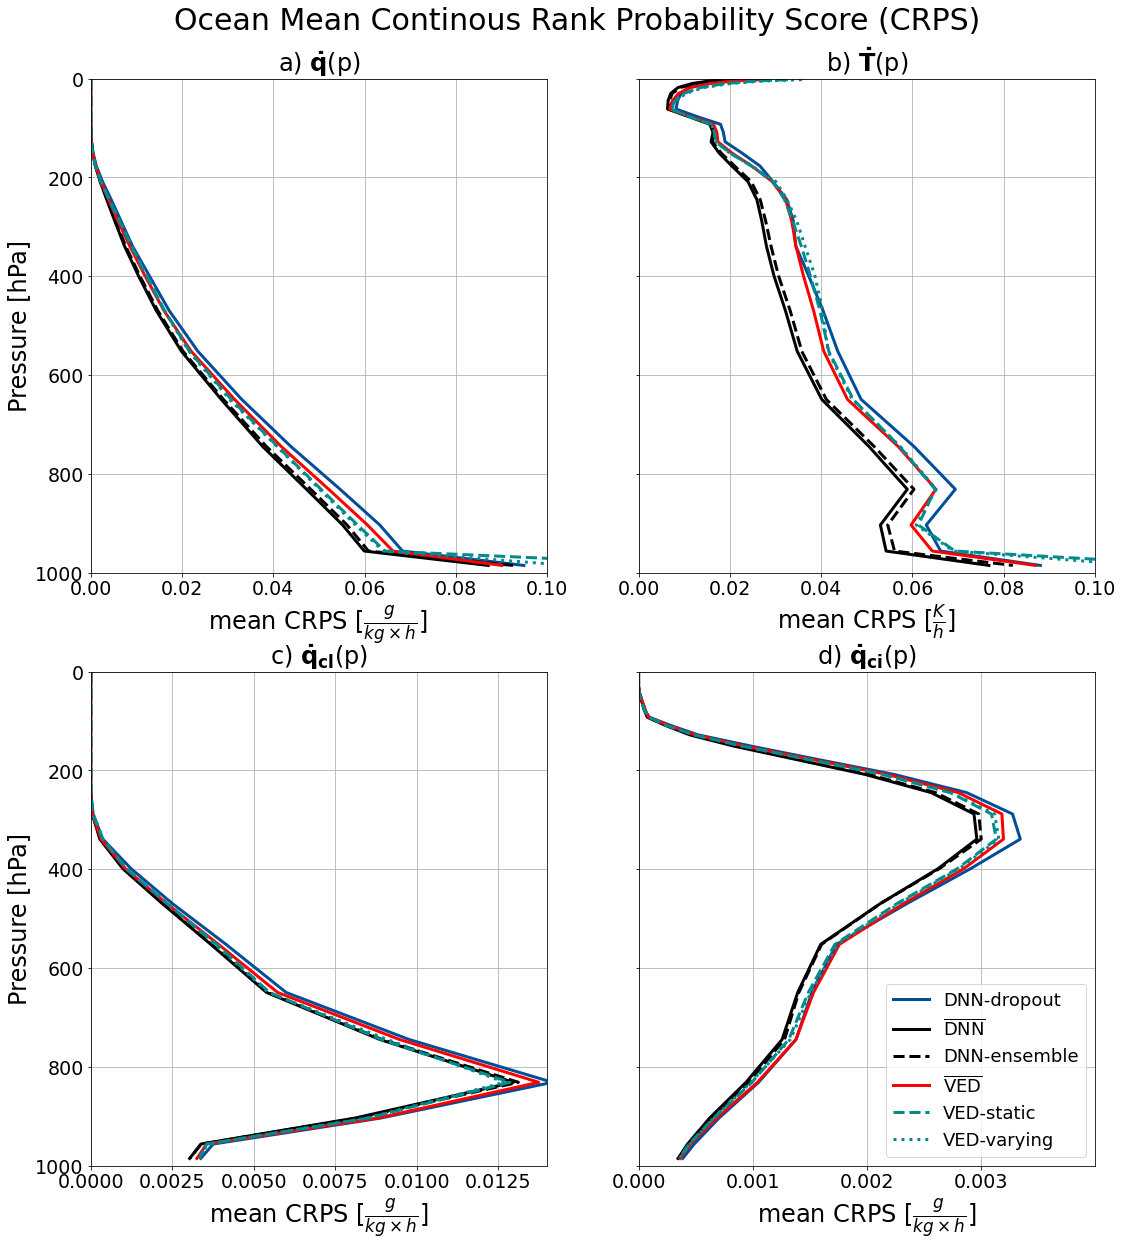

In [43]:
plt.figure(1,(18,20))

plt.suptitle('Ocean Mean Continous Rank Probability Score (CRPS)',fontsize=30,y=0.93)

plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(ocean_ext_resh),0:26],0)
                                        ,P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*np.mean(deter_7_ANN_lin_lev[np.int_(ocean_ext_resh),0:26],0)
         ,P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*np.mean(stoch_5_ANN_lin_lev[np.int_(ocean_ext_resh),0:26],0)
         ,P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*np.mean(deter_6_VED_lev_[np.int_(ocean_ext_resh),0:26],0)
         ,P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*np.mean(VED_1_0_5_7_lev_[np.int_(ocean_ext_resh),0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(ocean_ext_resh),0:26],0)
         ,P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.1)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(ocean_ext_resh),26:52],0),
                              P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*np.mean(deter_7_ANN_lin_lev[np.int_(ocean_ext_resh),26:52],0),
         P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*np.mean(stoch_5_ANN_lin_lev[np.int_(ocean_ext_resh),26:52],0),
         P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*np.mean(deter_6_VED_lev_[np.int_(ocean_ext_resh),26:52],0),
         P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*np.mean(VED_1_0_5_7_lev_[np.int_(ocean_ext_resh),26:52],0),
         P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(ocean_ext_resh),26:52],0),
         P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.10)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(deter_7_ANN_lin_lev[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(stoch_5_ANN_lin_lev[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(deter_6_VED_lev_[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(VED_1_0_5_7_lev_[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(ocean_ext_resh),52:78],0),
         P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')





sr=plt.gca()
plt.xticks(np.arange(0,0.014,0.0025))
plt.xlim(0,0.014)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(ANN_1_lin_dr_0_1_lev[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(deter_7_ANN_lin_lev[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,
         color='k',label=r'$\mathrm{\overline{DNN}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(stoch_5_ANN_lin_lev[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,'--',linewidth=3,
         color='k',label=r'DNN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(deter_6_VED_lev_[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,linewidth=3,
         color='r',label=r'$\mathrm{\overline{VED}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(VED_1_0_5_7_lev_[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,'--',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*np.mean(VED_1_alpha_arr_1_7_lev_[np.int_(ocean_ext_resh),78:104],0),
         P[0:26]/100,':',
         linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-3))

plt.xlim(0,0.0040)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)



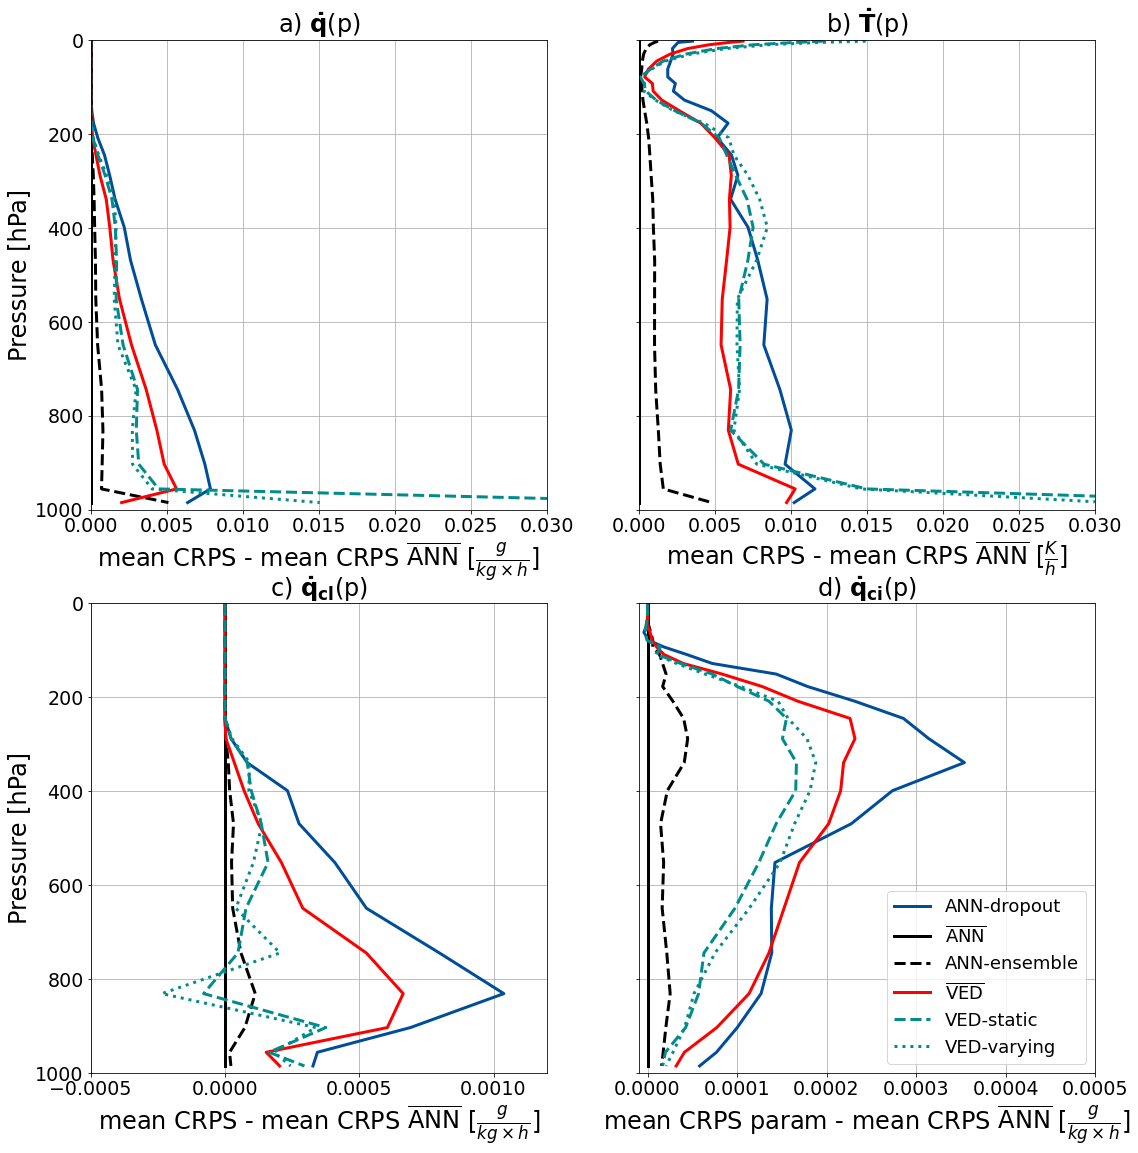

In [36]:
plt.figure(1,(18,19))
plt.subplot(2,2,1)


plt.plot(3600*1000*QBC_std_surf*(ANN_1_lin_dr_crps_ensemble_7_mem_mean-crps_ensemble_7_lin_mem_mean)[0:26],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*QBC_std_surf*(crps_ensemble_7_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[0:26],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*QBC_std_surf*(crps_ensemble_5_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[0:26],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*QBC_std_surf*(VED_crps_ensemble_6_mem_mean[0:26]-crps_ensemble_7_lin_mem_mean[0:26]),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*QBC_std_surf*(VED_1_crps_ensemble_0_5_mean[0:26]-crps_ensemble_7_lin_mem_mean[0:26]),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*QBC_std_surf*(VED_1_crps_ensemble_alpha_arr_1_mean[0:26]-crps_ensemble_7_lin_mem_mean[0:26]),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')






sr=plt.gca()
plt.xlim(0,0.03)
plt.ylim(0,1000)
#plt.xscale('log')
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS - mean CRPS $\mathrm{\overline{ANN}}$ [$\frac{g}{kg \times h}$] ',fontsize=24)
plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)


ax_2=plt.subplot(2,2,2)
plt.plot(3600*TBC_std*(ANN_1_lin_dr_crps_ensemble_7_mem_mean-crps_ensemble_7_lin_mem_mean)[26:52],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*TBC_std*(crps_ensemble_7_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[26:52],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*TBC_std*(crps_ensemble_5_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[26:52],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*TBC_std*(VED_crps_ensemble_6_mem_mean[26:52]-crps_ensemble_7_lin_mem_mean[26:52]),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*TBC_std*(VED_1_crps_ensemble_0_5_mean[26:52]-crps_ensemble_7_lin_mem_mean[26:52]),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*TBC_std*(VED_1_crps_ensemble_alpha_arr_1_mean[26:52]-crps_ensemble_7_lin_mem_mean[26:52]),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')


sr=plt.gca()
plt.xlim(0,0.03)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_2.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS - mean CRPS $\mathrm{\overline{ANN}}$ [$\frac{K}{h}$]',fontsize=24)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=24)


ax_3=plt.subplot(2,2,3)


plt.plot(3600*1000*CLDLIQBCTEND_std*(ANN_1_lin_dr_crps_ensemble_7_mem_mean-crps_ensemble_7_lin_mem_mean)[52:78],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN 1 7mem dr=0.01')


plt.plot(3600*1000*CLDLIQBCTEND_std*(crps_ensemble_7_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[52:78],P[0:26]/100,linewidth=3,color='k',label=r'deter 7 ANNs')
plt.plot(3600*1000*CLDLIQBCTEND_std*(crps_ensemble_5_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[52:78],P[0:26]/100,'--',linewidth=3,color='k',label=r'stoch 5 ANNs')

plt.plot(3600*1000*CLDLIQBCTEND_std*(VED_crps_ensemble_6_mem_mean[52:78]-crps_ensemble_7_lin_mem_mean[52:78]),P[0:26]/100,linewidth=3,color='r',label=r'deter 6 VEDs')


plt.plot(3600*1000*CLDLIQBCTEND_std*(VED_1_crps_ensemble_0_5_mean[52:78]-crps_ensemble_7_lin_mem_mean[52:78]),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')
plt.plot(3600*1000*CLDLIQBCTEND_std*(VED_1_crps_ensemble_alpha_arr_1_mean[52:78]-crps_ensemble_7_lin_mem_mean[52:78]),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha$ array 7 draws')







sr=plt.gca()
plt.xticks(np.arange(-5E-4,0.0012,0.0005))
plt.xlim(-5E-4,0.0012)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=24)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS - mean CRPS $\mathrm{\overline{ANN}}$ [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=24)

ax_4=plt.subplot(2,2,4)
plt.plot(3600*1000*CLDICEBCTEND_std*(ANN_1_lin_dr_crps_ensemble_7_mem_mean-crps_ensemble_7_lin_mem_mean)[78:104],P[0:26]/100,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(3600*1000*CLDICEBCTEND_std*(crps_ensemble_7_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[78:104],P[0:26]/100,linewidth=3,color='k',label=r'$\mathrm{\overline{ANN}}$')
plt.plot(3600*1000*CLDICEBCTEND_std*(crps_ensemble_5_lin_mem_mean-crps_ensemble_7_lin_mem_mean)[78:104],P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(3600*1000*CLDICEBCTEND_std*(VED_crps_ensemble_6_mem_mean[78:104]-crps_ensemble_7_lin_mem_mean[78:104]),P[0:26]/100,linewidth=3,color='r',label=r'$\mathrm{\overline{VED}}$')


plt.plot(3600*1000*CLDICEBCTEND_std*(VED_1_crps_ensemble_0_5_mean[78:104]-crps_ensemble_7_lin_mem_mean[78:104]),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(3600*1000*CLDICEBCTEND_std*(VED_1_crps_ensemble_alpha_arr_1_mean[78:104]-crps_ensemble_7_lin_mem_mean[78:104]),P[0:26]/100,':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xticks(np.arange(0,0.004,1E-4))

plt.xlim(-1E-5,0.0005)
plt.ylim(0,1000)
sr.invert_yaxis()
ax_4.set_yticklabels([])
plt.grid(True)
#plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'mean CRPS param - mean CRPS $\mathrm{\overline{ANN}}$ [$\frac{g}{kg \times h}$]',fontsize=24)
plt.title('d) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=24)
plt.legend(fontsize=18,loc=4)


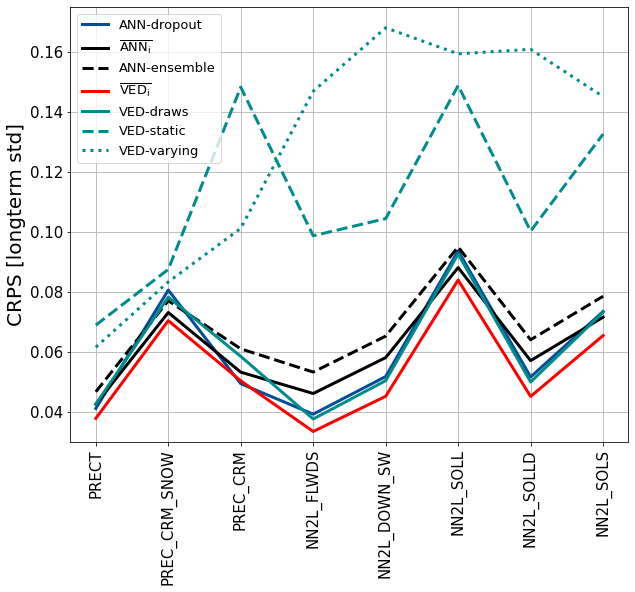

In [46]:
plt.figure(2,(10,8))


plt.plot(ANN_1_lin_dr_crps_ensemble_7_mem_mean[104:112],linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(crps_ensemble_7_lin_mem_mean[104:112],linewidth=3,color='k',label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(crps_ensemble_5_lin_mem_mean[104:112],'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(VED_crps_ensemble_6_mem_mean[105:113],linewidth=3,color='r',label=r'$\mathrm{\overline{VED_i}}$')

plt.plot(VED_1_crps_ensemble_0_0_mean[105:113],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(VED_1_crps_ensemble_0_5_mean[105:113],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(VED_1_crps_ensemble_alpha_arr_1_mean[105:113],':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')



sr=plt.gca()
#plt.yscale('log')
plt.ylim(0.03,0.175)
plt.grid(True)
plt.xticks(np.arange(crps_ensemble_7_lin_mem_mean[104:112].size),out_vars_VED[4:12],rotation='vertical',fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'CRPS [longterm std]',fontsize=20)
plt.legend(fontsize=13,loc=2)


In [47]:
SP_2D_VAR_updt=[r'Snow$_{CRM}$','Prec$_{CRM}$',r'Q$_{lw \ surf}$',
           r'Q$_{sw \ surf}$',r'Q$_{sol \ lw}$',r'Q$_{sol \ lw, \ diff}$',
           r'Q$_{sol \ sw}$',r'Q$_{sol \ sw, \ diff}$']

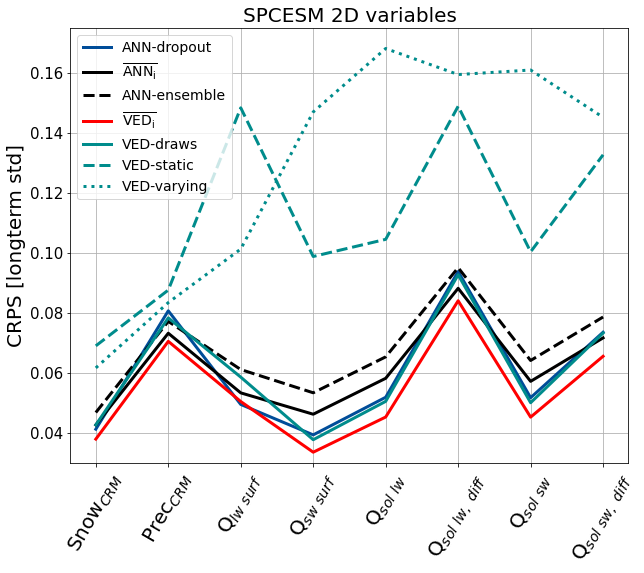

In [49]:
plt.figure(2,(10,8))


plt.plot(ANN_1_lin_dr_crps_ensemble_7_mem_mean[104:112],linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')


plt.plot(crps_ensemble_7_lin_mem_mean[104:112],linewidth=3,color='k',label=r'$\mathrm{\overline{ANN_i}}$')
plt.plot(crps_ensemble_5_lin_mem_mean[104:112],'--',linewidth=3,color='k',label=r'ANN-ensemble')

plt.plot(VED_crps_ensemble_6_mem_mean[105:113],linewidth=3,color='r',label=r'$\mathrm{\overline{VED_i}}$')

plt.plot(VED_1_crps_ensemble_0_0_mean[105:113],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(VED_1_crps_ensemble_0_5_mean[105:113],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(VED_1_crps_ensemble_alpha_arr_1_mean[105:113],':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')



sr=plt.gca()
#plt.yscale('log')
plt.ylim(0.03,0.175)
plt.grid(True)
plt.xticks(np.arange(crps_ensemble_7_lin_mem_mean[104:112].size),SP_2D_VAR_updt, rotation=60,fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.title('SPCESM 2D variables',fontsize=20)
plt.ylabel(r'CRPS [longterm std]',fontsize=20)
plt.legend(fontsize=14,loc=2)
